# Figure 12: probability of each possible sequence of observed neighbourhood infections and r takes value from the distribution $U[0, 0.7]$

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

### Importing required libraries

In [1]:
%matplotlib inline
import time
import numpy as np
import pylab as plt
import random
import multiprocessing as mp
from scipy.optimize import fsolve
from numpy import unique
from numpy import where
from sklearn.cluster import Birch
import itertools
import pandas as pd

### Importing required scripts

In [2]:
import importlib
import Gillespie_household_model_6neigh
import R_star_construct

importlib.reload(Gillespie_household_model_6neigh)
importlib.reload(R_star_construct)

do_Gillespie = Gillespie_household_model_6neigh.do_Gillespie
RstarAnal = R_star_construct.RstarAnal

### Parameters

In [3]:
h1,h2,h3,h4,h5,h6 = 2520,2520,1260,1260,840,840      # no. of households in each neighbourhood
n1,n2,n3,n4,n5,n6 = 2,2,4,4,6,6                      # size of households for each neighbourhood
N_neigh = 6

gamma = 0.2                                                 # recovery rate from infection
days = 100                                                  # no. of days in simulation
tStart, tEnd = 0, days                                      # start time and end time (days) of simulation

time_points = np.linspace(tStart, tEnd, days+1)  # time points for Gillespie output, daily
chains = 50000

H = np.array([h1,h2,h3,h4,h5,h6])
N = np.array([n1,n2,n3,n4,n5,n6])

In [4]:
nu = 3      # good range 1 to 6   # change this for supplementary results
beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]
alpha = beta/nu

alpha=round(alpha,2)
beta=round(beta,2)
alpha,beta

(0.27, 0.8)

### Running the sims for $6$ neighbourhoods

In [5]:
r_vecs = np.zeros((chains,N_neigh))        # initialise array to store r values from each run
alpha_vec = np.zeros(chains, dtype=object) # intialising array to store each set of alpha values
                                           # we simulate proportion of contacts reserved for ones own 
for chain in range(chains):                # neighbourhood each run  

    p_rand = np.random.uniform(0,0.7,6) # realisation of r for neighbourhoods

    p_reserve = np.array([p_rand[0],p_rand[1],p_rand[2],p_rand[3],p_rand[4],p_rand[5]])
    r_vecs[chain,:] = p_rand[0],p_rand[1],p_rand[2],p_rand[3],p_rand[4],p_rand[5]
    rho = np.zeros((N_neigh,N_neigh))

    for i in range(N_neigh):   # using the r values to calculate the rho values
        for j in range(N_neigh):
            rho[i,j] = (1-p_reserve[i])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
        rho[i,i] = p_reserve[i] + (1-p_reserve[i])*(1-p_reserve[i])*H[i]*N[i]/(np.sum((1-p_reserve)*H*N))
    alpha_vec[chain] = alpha*rho   # saving all 'alpha' vectors for each simulation run

t = time.process_time()             # recording how long takes to run
pool = mp.Pool(mp.cpu_count())      # start parallelisation

Infs = np.zeros(N_neigh)
Infs[0] = 1                   # not actually needed just left in code atm

params_dict = {'beta': [beta,beta,beta,beta,beta,beta],    # parameter dictionary input into SSA
               'gamma':gamma,
               'n': N, 
               'h': H,
               'inf0': Infs,
               'tStart':tStart,
               'tEnd':tEnd,
               'time_points':time_points
              }
# we create a seperate dictionary containing the alpha values for each run and then merge the 2 together    
neigh6_results8 = pool.map(do_Gillespie, [{**params_dict,**{'alpha': alpha_vec[i]}} for i in range(chains)])
   
pool.close()                                 # end parallelisation
elapsed_time = time.process_time() - t       # time taken to run sims
print("elapsed time: ", elapsed_time)    

### Unpacking the results and finding the probability of each sequence of observed infections occurring

In [6]:
obs_outbreak8 = np.zeros((chains,N_neigh),dtype=int)   # initialise array for first neighbourhood observed outbreak

for i in range(chains):                                   # unpacking results
    if len(neigh6_results8[i][0]) == N_neigh:
        obs_outbreak8[i,:] = neigh6_results8[i][0]

ext_ind = np.where(np.all(obs_outbreak8 == 0, axis=1))[0]       
seq_out8 = obs_outbreak8[~np.all(obs_outbreak8 == 0, axis=1)]    # removing runs that didn't take off
r_vecs8 = np.delete(r_vecs, ext_ind, axis=0)                     # removing corresponding r values

In [7]:
neighs = np.arange(0,6,1)                       # creating array of all the possible neighbourhood infection
seqs = list(itertools.permutations(neighs,6))   # sequences
seq_count8 = np.zeros(len(seqs))     # recording how many times each possible sequence of neighbourhoods occurs
for i in range(len(seqs)):
    seq_count8[i] = np.count_nonzero(np.count_nonzero(seq_out8 == seqs[i],axis=1) == N_neigh)

Saving the results

In [8]:
# save results so don't have to keep rerunning
#np.savetxt('seq_count8.csv', seq_count8, delimiter=',')
#np.savetxt('number_of_outbreaks_rran.csv', [len(seq_out8)], delimiter=',')

Loading the results in

In [14]:
# you will need to change these to you file paths
file_path = 'C:/Users/abby2/Documents/SAMBa/Demographic clustering project/Publication_results/seq_count8.csv'
file_path2 = 'C:/Users/abby2/Documents/SAMBa/Demographic clustering project/Publication_results/number_of_outbreaks_rran.csv'

# Load the data from the CSV file into a pandas DataFrame
seq_count8 = pd.read_csv(file_path, header=None)
number_of_outbreaks = pd.read_csv(file_path2, header=None)
num_out = number_of_outbreaks.iloc[:, 0][0]
neighs = np.arange(0,6,1)                       # creating array of all the possible neighbourhood infection
seqs = list(itertools.permutations(neighs,6))   # sequences
seq_counts8 = np.zeros(len(seqs))
seq_counts8[:] = seq_count8.iloc[:, 0]    # reformat as an array

data = np.zeros((len(seqs),len(seqs)))
data[:,1] = seq_counts8/num_out
data[:,0] = np.arange(0,len(seqs),1)

y_coordinates = data[:, 1].reshape(-1, 1)

Finding the sequences occurring in the top 6.9\%

In [7]:
top_seq = 0   # initialise counter
top_10 = int(sum(seq_counts8)*0.069)   # calculate how many outbreaks in the top 6.9%

# sort indices of seq_counts_nu so they are in decreasing order of how many times each sequence occurs
indices_ordered = np.argsort(seq_counts8)[::-1]
for i in range(len(seq_counts8)):                    # loop over all sequences that occur
    top_seq += seq_counts8[indices_ordered[i]]       # add next top sequenace no. of outbreaks to counter
    if top_seq >= top_10:                            # if have atleast reached how many outbreaks occur in top 6.9%
        count = i                 # record index of last sequence included (in reordered set)
        diff = 0                  # initialise difference counter
        if top_seq > top_10:      # if not all outbreaks in last sequence included counted in top 6.9%
            diff = top_seq - top_10    # record difference
        break

top_seqs = []           # initialise array to record each sequence instance that occurs in the top 6.9%
               
for j in range(count-1):      # loop over sequences that occur in the top 6.9% (except last one)
    for k in range(int(seq_counts8[indices_ordered[j]])):   # loop over the no. of times each sequence occurs                         
        top_seqs.append(seqs[indices_ordered[j]])         # append sequence to top seqs                      

### need to add in last entries of diff 
for l in range(int(diff)):             # loop over no. of times last sequence occurs (might not be the complete no. of times)
    top_seqs.append(seqs[indices_ordered[count-1]])     # append to top seqs   

Saving the results

In [15]:
#np.savetxt('top_seqs_rrand.csv', top_seqs, delimiter=',')

### Producing figure with clustering analysis

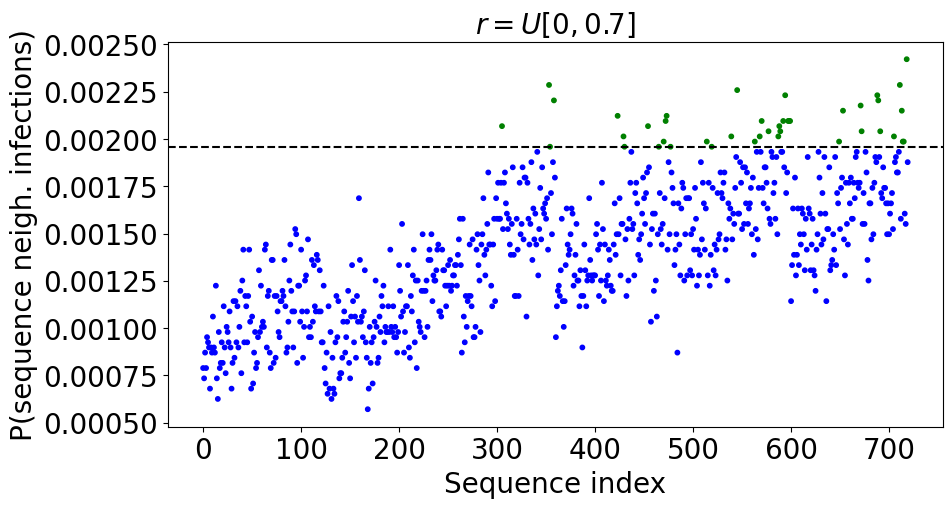

In [15]:
figure = plt.figure(figsize=(10,5))

y=data[:, 1]
line1_value = 72/num_out   # corresponds to top 6.9%
colors = np.where(y < line1_value,'blue', 'green')
sorted_indices = np.argsort(data[:, 1])
#data[:,1] = data[sorted_indices,1]
plt.scatter(data[:, 0], data[:, 1],s=10,color=colors)
# show the plot
plt.axhline(line1_value, color='black', ls='--')

plt.xticks(color='black', fontsize=20)
plt.yticks(color='black', fontsize=20)
plt.xlabel('Sequence index', color='black', fontsize=20)
plt.ylabel('P(sequence neigh. infections)', color='black', fontsize=20)
plt.title(r'$r=U[0,0.7]$',fontsize=20)
plt.savefig('all_seqences_rrand.pdf', bbox_inches='tight')
plt.show()